## Train model for all glaciers, blocking by glacier


In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from matplotlib import pyplot as plt

from model_functions import select_variables
from model_functions import train_xgb_model

In [2]:
# Specify filepaths and filenames.
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-06-27_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_all = data[data['balance_netto'].notna()]
glacier_data_all.reset_index(drop=True, inplace=True)


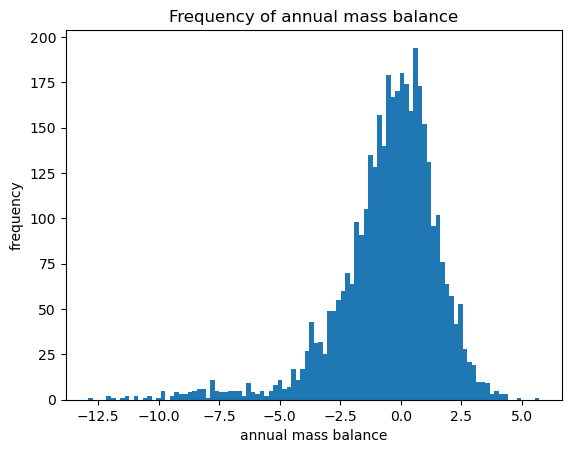

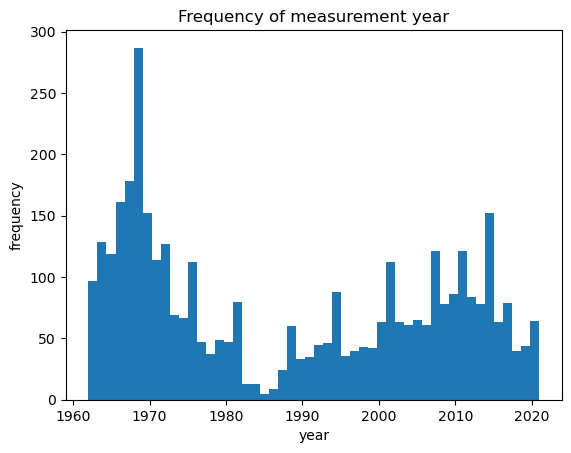

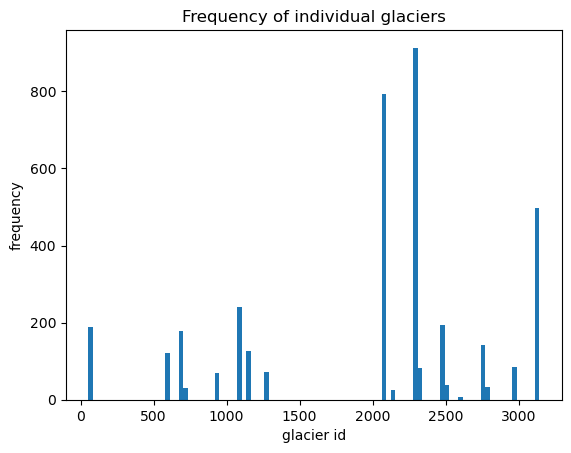

In [3]:
plt.figure()
glacier_data_all['balance_netto'].plot.hist(bins=100)
plt.title('Frequency of annual mass balance')
plt.ylabel('frequency')
plt.xlabel('annual mass balance')
plt.show()

plt.figure()
glacier_data_all['year'].plot.hist(bins=50)
plt.title('Frequency of measurement year')
plt.ylabel('frequency')
plt.xlabel('year')
plt.show()

plt.figure()
glacier_data_all['BREID'].plot.hist(bins=100)
plt.title('Frequency of individual glaciers')
plt.ylabel('frequency')
plt.xlabel('glacier id')
plt.show()

In [4]:
# Manually select test glaciers
test_glaciers = [54, 703, 941, 1135, 1280, 2085, 2320, 2768, 2478, 2769, 3127, 3141]

df_test = glacier_data_all[glacier_data_all['BREID'].isin(test_glaciers)]
# 54 has 37 points
# 703 has 13 points
# 1280 has 25 points
# 2478 has 22 points
# 2769 has 10 points
# 3127 has 60 points
# test has 323 points in total

df_train = glacier_data_all[~glacier_data_all['BREID'].isin(test_glaciers)]

In [5]:
base_cols = ['altitude','aspect','slope','altitude_climate']
temp_cols = ['t2m_oct','t2m_nov','t2m_des','t2m_jan','t2m_feb','t2m_mar','t2m_apr','t2m_may','t2m_jun','t2m_jul','t2m_aug','t2m_sep']
prec_cols = ['tp_oct','tp_nov','tp_des','tp_jan','tp_feb','tp_mar','tp_apr','tp_may','tp_jun','tp_jul','tp_aug','tp_sep']
label_cols = ['balance_netto']

df_train_X = select_variables(df_train, base_cols, temp_cols, prec_cols)
df_train_y = select_variables(df_train, label_cols)
df_test_X = select_variables(df_test, base_cols, temp_cols, prec_cols)
df_test_y = select_variables(df_test, label_cols)

# 1409 for training (19 glaciers), 323 for testing (12 glaciers)
X_train, y_train = df_train_X.values, df_train_y.values
X_test, y_test = df_test_X.values, df_test_y.values

In [6]:
# Shuffle df_train, get X and y values
df_train_s = df_train.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

In [7]:
df_train_X_s = select_variables(df_train_s, base_cols, temp_cols, prec_cols)
df_train_y_s = select_variables(df_train_s, label_cols)

X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

gp_s = np.array(df_train_s['BREID'].values)

In [8]:
# Use five folds
group_kf = GroupKFold(n_splits=5)
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

In [9]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -1.712346463319846
Grid search best hyperparameters:  {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200}
Cross validation scores per fold:  [-1.04266768 -2.18351812 -2.07217911 -0.75626956 -2.50709785]
Mean cross validation score:  -1.712346463319846
Standard deviation:  0.6849328059931279


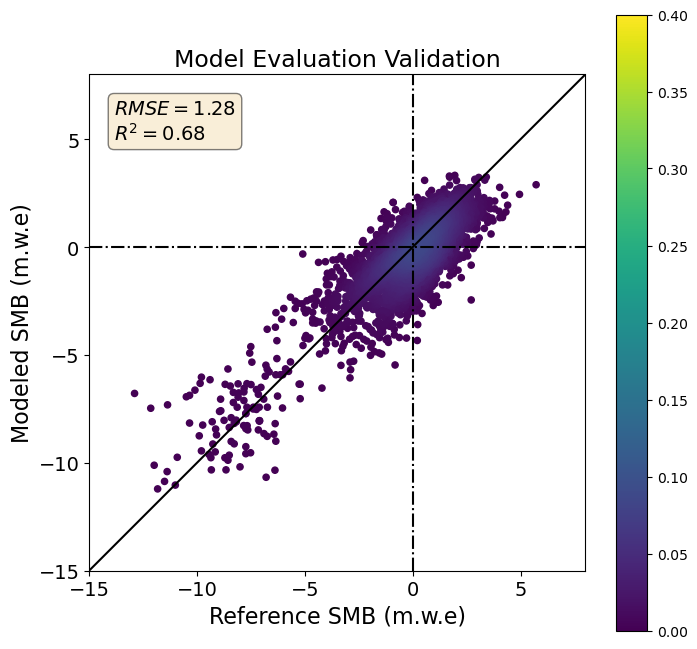

In [10]:
# Train model
best_model = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, scorer='neg_mean_squared_error')